# Problem Statement

The purpose of this project is to develop a model that can answer natural language queries about famous people. Further, the project should allow for the source content to be continually updated externally without requiring the model to be retrained.

Specifically, the model is based on the **Wikipedia Biography** pages. Each person has different rows of information pertaining to their notable accomplishments and details about their life. There are a large number of types of information that can appear as rows in the biography tables, however they are relatively uniform. The keys of the rows will be referred to as "relations".

For example Alexander Hamilton has information about the President he worked for as Secretary of State, birth date, date of death, parents' names, etc.

The model should be able to correctly answer natural language variations of questions such as:

When was Alexander Hamilton born?

What is the birth date of Alexander Hamilton?

When is Alexander Hamilton's birthday?

# Introduction

Key-Value Memory Networks (KVMemNets) are a type of neural architecture designed to enhance a model’s ability to store and retrieve facts from an external memory. They're particularly useful in reasoning tasks that require looking up information and making connections between entities or events.

Memory networks learn to access external memory stores (a database or, in the case of this assignment, a dictionary). Key-Value Memory Networks specifically assume that the external memory store is organized as a dictionary with keys and values. In theory, memory networks are useful when one wants a neural network to be able to know a lot of information but we don't want to try to encode that information directly into the parameters of the network. This means information can be changed in the external memory database without retraining the neural network.

For example, given a question like “Who is the CEO of Microsoft?”, the model retrieves:

Keys: Natural language variations of facts (e.g., "Microsoft Chief Executive Officer")

Values: Specific answers (e.g., "Satya Nadella")

A key-value memory network learns an embedding such that the question has a high **cosine similarity** to a particular key in the external dictionary. Because there are many keys that need to be matched against, key-value memory networks implement an **attention-scoring** mechanism to select a key. Because attention is a probabilistic score, the key-value memory network retrieves a sum of embeddings weighted according to the attention score. This weighted embedding is then compared to values using a second attention-scoring mechanism. The value with the highest cosine similarity can then be retrieved and returned as the answer.

Memory networks were an important part of the evolution of question-answering systems that have been eclipsed by transformers. However, the attention mechanism in a key-value memory network is very similar to the self-attention inside a transformer, so implementing a key-value memory network is a really great way to experiment and learn about self-attention without the added complexity of transformers.

Key-value memory networks are described in this [paper](https://arxiv.org/abs/1606.03126).

# Imports



In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import re
import os
import json
import random
import numpy as np
import pickle
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from google.colab import files
import datetime


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

Unidecode is useful for getting rid of issues that arise from unicode. It eliminates a lot of edge cases that come up with unicode.

In [ ]:
!pip install unidecode

In [ ]:
import unidecode

To have a reduced vocabulary, an unknown "unk" token is created and added to the vocabulary. The token index in the vocabulary and `UNK_ID` must match.

In [ ]:
UNK = 'unk'
UNK_ID = '0'

# Utilities

Stem words

In [ ]:
# Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= [ps.stem(word) for word in text]
    return text

Simple tokenizer that only keeps letters and numbers.

In [ ]:
def tokenize(line):
    line = re.sub(r'[^a-zA-Z0-9]', ' ', unidecode.unidecode(line)) # remove punctuation
    line = line.lower().split()  # lower case
    return line

A standard vocabulary object class

In [ ]:
class Vocab:
    def __init__(self, name = 'vocab'):
        self.name = name
        self._word2index = {}
        self._word2count = {}
        self._index2word = {}
        self._n_words = 0

    def get_words(self):
      return list(self._word2count.keys())

    def num_words(self):
      return self._n_words

    def word2index(self, word):
      return self._word2index[word]

    def index2word(self, word):
      return self._index2word[word]

    def word2count(self, word):
      return self._word2count[word]

    def add_sentence(self, sentence):
        for word in tokenize(sentence):
            self.add_word(word)

    def add_word(self, word):
        if word not in self._word2index:
            self._word2index[word] = self._n_words
            self._word2count[word] = 1
            self._index2word[self._n_words] = word
            self._n_words += 1
        else:
            self._word2count[word] += 1

Make a bag of words from a sentence, given a vocabulary. Can return a bag of word counts or a a bag of word presences.

In [ ]:
def multihot(s, vocab, preserve_counts = False):
  tokens = np.array([vocab.word2index(t) for t in tokenize(s)])
  mhot = np.zeros((tokens.size, vocab.num_words()))
  mhot[np.arange(tokens.size), tokens] = 1
  if preserve_counts:
    return mhot.sum(0)
  else:
    return mhot.sum(0) >= 1


If using a reduced vocabulary, use this to replace out-of-vocab words. If using it, merge it with `multihot` above to avoid tokenizing twice.

In [ ]:
def unkit(s, vocab):
  return ' '.join(list(map(lambda x: UNK if x not in vocab._word2index else x, tokenize(s))))

# Download and Process Data

The code below will download the dataset and process it to create two things:

- `DB`: a hash table that map titles of biography wikipedia articles to table information. The table information is represented as a nested hash table containing relations as keys, and associated values. For example, `DB['alexander hamilton'] = {'party': 'federalist',
 'spouse': 'elizabeth schuyler', ...}`

- `VOCAB`: A vocabulary object that maps words to tokens and vice versa.

In [ ]:
!git clone https://github.com/rlebret/wikipedia-biography-dataset.git

In [ ]:
!cat wikipedia-biography-dataset/wikipedia-biography-dataset.z?? > tmp.zip
!unzip -o tmp.zip
!rm tmp.zip

Get all the wikipedia titles.

In [ ]:
train_titles = []
with open("wikipedia-biography-dataset/train/train.title", "r") as file:
  for line in file:
    train_titles.append(line.rstrip())

Boxes contain all the information, with each line corresponding to a title in `titles`.

In [ ]:
train_boxes = []
with open("wikipedia-biography-dataset/train/train.box", "r") as file:
  for line in file:
    train_boxes.append(line.rstrip())

This will make the DB object, a dictionary of dictionaries for each wikipedia title, which is more or less the same as names. This function only keeps politicians (containing the "office" key term) and strips out information about images. It can be improved in many ways.

In [ ]:
# Make a dictionary of dictionaries
def make_db(titles, boxes):
  db = {} # The DB
  # Iterate through titles
  for i in tqdm(range(len(titles))):
    box = boxes[i] # Grab the corresponding box information
    d  = {} # Inner dictionary
    # Build a dict for the ith entry
    # grab each key:value pair
    for pair in re.findall(r'([a-zA-Z_]+)[0-9]*\:([\w\d]+)', box):
      key, value = pair
      # Do a bit of cleaning
      key = key.strip()
      value = value.strip()
      # If the key contains the word image, we probably don't want to keep it
      if 'image' not in key:
        # The regex maintains underscores, strip those off
        if key[-1] == '_':
          key = key[:-1]
        # Make a new entry in inner dictionary if we don't have one
        if key not in d:
          d[key] = value
        # Keys with compound values are split up, which is annoying, so put them back together
        else:
          d[key] += ' ' + value
    # If it has an office key, keep it.
    if 'office' in d:
      db[titles[i]] = d
  return db

Build the vocab from the DB. Convert the whole thing into a string, tokenize it, and feed the surviving words into the vocab.

In [ ]:
def make_vocab(DB):
  # Make the vocab object
  vocab = Vocab()
  # Tokenize the data by converting the entire DB into a string
  tokens = tokenize(str(DB))
  # Iterate through all the tokens (tqdm provides a progress bar)
  for t in tqdm(tokens):
    vocab.add_word(t)
  return vocab

If rare words are discarded, this will rebuild the vocab.

In [ ]:
def reduce_vocab(vocab, min_word_occurrence = 2):
  # make a new vocab
  vocab2 = Vocab("top")
  # Add the UNK token
  vocab2.add_word(UNK)
  # Iterate through vocabulary
  for w in list(vocab._word2count.keys()):
    count = vocab._word2count[w]
    idx = vocab._word2index[w]
    # If the word count passes threshold, add it to the new vocabulary object
    if count >= min_word_occurrence:
      vocab2.add_word(w)
      vocab2._word2count[w] = count
  # Return the new vocabulary object
  return vocab2

Make the DB

In [ ]:
DB = make_db(train_titles, train_boxes)

Make the VOCAB

In [ ]:
VOCAB = make_vocab(DB)
print(VOCAB.num_words())

## Save Processed Data

Save the processed dataset to Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
with open("drive/MyDrive/data", "wb") as f:
  pickle.dump(DB, f, protocol=None, fix_imports=True, buffer_callback=None)

In [ ]:
with open('drive/MyDrive/vocab', 'wb') as f:
    pickle.dump(VOCAB, f, protocol=None, fix_imports=True, buffer_callback=None)

## Load processed data

In [ ]:
with open("drive/MyDrive/vocab", "rb") as f:
  VOCAB = pickle.load(f)

In [ ]:
with open("drive/MyDrive/data", "rb") as f:
  DB = pickle.load(f)

We need to generate questions for each type of relation. There a number of ways to do this.

The simplest is to just assume that a question is the name of a person and a relation, e.g., "Alexander Hamilton birth date". Another way would be to create templates for each type of relation. For example the "birth date" relation would have the following template: "When was [name] born?", filling in the [name].

In this implementation, Chat GPT was utilized by providing the list of relations we're interested in and asked to generate templates, which worked quite well.

In [ ]:
relations_list = [
    'office',
    'article_title',
    'name',
    'term_start',
    'birth_date',
    'birth_place',
    'term_end',
    'predecessor',
    'party',
    'successor',
    'alma_mater',
    'death_date',
    'spouse',
    'death_place',
    'nationality',
    'religion',
    'children',
    'occupation',
    'profession',
    'residence'
]
templates = {
    "office": [
        "What office does XYZ hold",
        "Which office is XYZ in",
        "Do you know what office XYZ holds",
        "Can you tell me the office of XYZ",
        "What is the official position of XYZ"
    ],
    "article_title": [
        "What is the title of XYZ article",
        "Do you know the article title of XYZ",
        "Can you tell me XYZ article title",
        "What is the name of XYZs article",
        "What is XYZs article called"
    ],
    "name": [
        "What is XYZ name",
        "Do you know XYZ name",
        "Can you tell me the name of XYZ",
        "What is the full name of XYZ",
        "What is XYZ called"
    ],
    "term_start": [
        "When did XYZ term start",
        "When did XYZ begin their term",
        "Do you know when XYZ term started",
        "When did XYZ take office",
        "When did XYZ term officially begin"
    ],
    "birth_date": [
        "When was XYZ born",
        "What is XYZ birth date",
        "When is XYZ birthday",
        "Do you know when XYZ was born",
        "When did XYZ come into the world"
    ],
    "birth_place": [
        "Where was XYZ born",
        "What is XYZ birthplace",
        "Where did XYZ come into the world",
        "Do you know where XYZ was born",
        "Where is XYZ birth location"
    ],
    "term_end": [
        "When did XYZ term end",
        "When did XYZ finish their term",
        "Do you know when XYZ term ended",
        "When was XYZ term over",
        "When did XYZ term officially end"
    ],
    "predecessor": [
        "Who was in office before XYZ",
        "Who did XYZ replace",
        "Do you know who XYZ predecessor was",
        "Who was XYZ predecessor",
        "Who held the position before XYZ"
    ],
    "party": [
        "What party does XYZ belong to",
        "Which party is XYZ a member of",
        "What is XYZ political party",
        "Do you know which party XYZ is with",
        "Which political party is XYZ affiliated with"
    ],
    "successor": [
        "Who succeeded XYZ",
        "Who took over after XYZ",
        "Do you know who XYZ successor is",
        "Who followed XYZ in office",
        "Who is XYZ successor"
    ],
    "alma_mater": [
        "Where did XYZ go to school",
        "What is XYZ alma mater",
        "Do you know which school XYZ attended",
        "Where did XYZ get their degree",
        "Which college did XYZ go to"
    ],
    "death_date": [
        "When did XYZ die",
        "What is XYZ death date",
        "When did XYZ pass away",
        "Do you know when XYZ died",
        "When did XYZ life end"
    ],
    "spouse": [
        "Who is XYZ spouse",
        "Is XYZ married If so to whom",
        "Do you know who XYZ spouse is",
        "Who is XYZ married to",
        "Who is XYZ partner"
    ],
    "death_place": [
        "Where did XYZ die",
        "What is XYZ place of death",
        "Do you know where XYZ died",
        "Where did XYZ pass away",
        "What is XYZ death location"
    ],
    "nationality": [
        "What is XYZ nationality",
        "Which country is XYZ from",
        "Do you know XYZ nationality",
        "Where is XYZ from",
        "What country does XYZ belong to"
    ],
    "religion": [
        "What is XYZ religion",
        "Which religion does XYZ follow",
        "Do you know XYZ religion",
        "What faith does XYZ practice",
        "What is the religion of XYZ"
    ],
    "children": [
        "Does XYZ have children",
        "Who are XYZ children",
        "Do you know about XYZ children",
        "Can you tell me about XYZ children",
        "How many children does XYZ have"
    ],
    "occupation": [
        "What does XYZ do for a living",
        "What is XYZ occupation",
        "Do you know what XYZ job is",
        "Can you tell me XYZ occupation",
        "What work does XYZ do"
    ],
    "profession": [
        "What is XYZ profession",
        "What does XYZ do professionally",
        "Do you know XYZ profession",
        "Can you tell me about XYZ profession",
        "What is the professional role of XYZ"
    ],
    "residence": [
        "Where does XYZ live",
        "What is XYZ residence",
        "Do you know where XYZ lives",
        "Can you tell me about XYZ home",
        "Where is XYZ residence"
    ]
}


In [ ]:
# create a reduced version of the vocabulary with a minimum of 2 occurrences.
vocab_reduced = reduce_vocab(VOCAB, 2)

In [ ]:
# Uses the reduced vocabulary to find an input word
def get_reduced_string(s):
  tokens = tokenize(s)

  out_list = []
  for t in tokens:
      if t in vocab_reduced._word2index:
          out_list.append(t)

  if len(out_list) > 0:
      return ' '.join(out_list)
  else:
      return None

In [ ]:
# Reduce DB based on the reduced vocabulary
# Keep only relations and values that are in the reduced vocab
db2 = {}
for key, value in DB.items():
    person_key = get_reduced_string(key)
    if person_key is None:
        continue

    # person = {person_key: {}}
    relations = {}
    for relation, val in value.items():
        if relation not in templates:
            continue
        red_ = get_reduced_string(val)
        if red_ is not None:
            relations[relation] = red_
    if len(relations) > 0:
        db2[person_key] = relations


## Data example

Get to know your data.

In [ ]:
db2["alexander hamilton"]

{'name': 'alexander hamilton',
 'office': '1st united states secretary of the treasury senior officer of the army delegate to the congress of the confederation from new york',
 'term_start': 'september 11 1789 december 14 1799 november 3 1788 november 4 1782',
 'term_end': 'january 31 1795 june 15 1800 march 2 1789 june 21 1783',
 'predecessor': 'position established george washington egbert benson seat established',
 'successor': 'oliver wolcott jr james wilkinson seat abolished seat abolished',
 'birth_date': '11 january 1755',
 'birth_place': 'charlestown nevis british west indies',
 'death_date': 'july 12 1804 aged 47 or 49',
 'death_place': 'new york city new york u',
 'party': 'federalist',
 'spouse': 'elizabeth schuyler',
 'children': 'philip angelica alexander james alexander john church william stephen eliza holly phil',
 'alma_mater': 'kings college new york',
 'religion': 'presbyterian episcopalian convert',
 'article_title': 'alexander hamilton'}

# Implementation of the Key-Value Memory Network

This [paper](https://arxiv.org/abs/1606.03126) describes the key-value memory networks in detail, which is also sketched out below.

A key-value memory network takes a natural language question. This question will be converted into a bag-of-words (i.e., a multihot) Call this $x$ and it is a 1D tensor of vocabulary length.

![KVMemNet architecture](https://github.com/markriedl/kvmemnet-assignment/blob/32479dd1e88a9f8dfc72f11ccb8e9e0e1f78905f/kvmemnet-inside.png?raw=true)

The KVMemNet will contain a linear layer (or embedding layer) that will produce a 1D embedding of the question $q=A(x)$.

The KVMemNet will also take in a stack of keys as a tensor of shape `num_keys x vocab_size`. Each row is embedded using the same embedding, $k=A(keys)$, producing a tensor of shape `num_keys x embed_dim`. How this stack of keys is chosen will be discussed below.

The KVMemNet will take in a third input, a stack of values associated with the stack of keys. This will also be of shape `num_values x vocab_size`. Each row is embedded using the same embedding, $v=A(values)$, producing a tensor of shape `num_keys x embed_dim`.

The KVMemNet will also contain a second linear embedding layer, $B$. More on this later.

Once we have `q`, `k`, and `v` embeddings, the next step is to use `q` and `k` to compute attention scores that can be applied against `v`. $A$ can be thought of as learning how to make questions and the keys that should match against values that have received the same treatment.

The attention scores `p` are computed by taking the inner-product (`torch.inner()`) between `q` and `k`. The result will be a 1D tensor with `num_keys` length. Use softmax so that `p` contains scores between 1.0 and 0.0.

Next apply the `p` attention scores against `v` to apply a weight against each value in the stack of values. One should be highly weighted and the rest less weighted. Sum all the weighted values up to create a 1D tensor `o` of feature weights of length `embed_dim`. `p` can be thought of as how much of each value gets selected. Then they all get combined together and the feature weights are proportional to how much each value was attended to. The `torch.matmul()` can do the multiplication and summing in one step.

The KVMemNet forward function should return this tensor of feature weights `o`.

A quick note on `k` and `v`. We can't send the entire set of keys and values in our database through the network's forward function. Instead there should be a selection mechanism that selects just a subset of the database. This subset should contain the best key for the question $x$ to match against, and its corresponding value. A shallow selection process is assumed that can narrow down the key-value pairs to a relatively small set, one of which will be best. For example, if the question involves "Alexander Hamilton", we can reasonably guess that the best key-value pair is in the part of the database associated with the named person.

We are not done though. What about our linear layer $B$? Suppose variable `Y` contains our entire set of values in our databse as bags of words. $B$ is going to be used to embed our entire set of database values $y=B(Y)$. $B$ can be thought of as learning how to make all the values look like the feature weights output by the model such that the highest cosine similarity corresponds to the correct value taken from *all* values in the database.

$B$ should live inside the KVMemNet object so that its parameters become trainable, but we do not use $B$ in the KVMemNet's forward function. $B$ will get used to prepare the stack of all values in the database for training. It will bet used in the training loop but outside of the forward function. This is a bit unusual, but necessary to figure out the correct target (the true index of the best value to match against) for training.

The above explantion only implements *single-hop* retrieval. *multi-hop* retrieval allows the results of one retrieval to inform a second (and third and so on) to get the right retrieval. This would be used in the case where the answer cannot be inferred directly from the question in a single retrieval, such as "What was the founding date of the country that Alexander Hamilton was born in?". To implement multi-hop retrieval, the KVMemNet will have additional linear layers $R_1...R_n$. Each $R_{i}$ will do a linear transform on `q` then attention will score and retrieve values as feature weights `o`. This will be sent to the next $R_{i+1}$ and so on until the hops are complete. This final `o` will be returned.

In [ ]:
class KVMemNet(nn.Module):
  def __init__(self, vocab_size, embed_dim):
    super(KVMemNet, self).__init__()
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim
    self.linear_a = nn.Linear(vocab_size, embed_dim)
    self.linear_b = nn.Linear(vocab_size, embed_dim)
    self.dropoutq = nn.Dropout(0.5)
    self.dropoutk = nn.Dropout(0.5)
    self.dropoutv = nn.Dropout(0.5)

  def forward(self, x, keys, values):
    output = None
    q = self.linear_a(x)
    k = self.linear_a(keys)
    v = self.linear_a(values)

    q = self.dropoutq(q)
    k = self.dropoutq(k)
    v = self.dropoutq(v)

    ip = torch.inner(k, q)
    softmax = F.softmax(ip, dim=0)
    output = torch.matmul(softmax, v)

    return output

The following describes the steps to set up a training loop, including the training of the $B$ layer.

![The KVMemNet being used in the training loop](https://github.com/markriedl/kvmemnet-assignment/blob/main/kvmemnet-outside.png?raw=true)

# Training

Only a subset of all key-value pairs should be put into the KVMemNet. We need a technique for sub-selecting from all the key-value pairs in `DB`. One option is to just use the ones that are directly associated with the person (Alexander Hamilton has 23). Some key-value pairs from another person's entries in the database are mixed in to help ensure against accidental overfitting.

The final challenge in the training loop is that there may still be too many unique values in `Y` to encode and create one big tensor. We can at least use the values that were sent to the KVMemNet, along with as many other randomly selected values as can fit into the GPU's memory.

In [ ]:
# This function is strictly not needed as callers can simply use the global db2
# which is the reduced db. However, this is being provided as a convenience so
# that callers already using it do not need to change.
def load_DB():
    return db2


In [ ]:
# Some common functions needed for preparing data for initial training and for
# inference in Part E

# this function takes one person and extracts keys and values
# it handles th logic of only selecting relations that are in the top 20
# frequent list and therefore have templates defined
def extract_keys_values(person):
  orig_keys = []
  person_keys = []
  person_values = []
  for relation in person[1].keys():
      if templates.get(relation) is not None:
          orig_keys.append(relation)
          person_keys.append(" ".join([person[0], relation]))
          person_values.append(person[1][relation])

  return orig_keys, person_keys, person_values

# this function returns "n" random names from the database
# also provides an option to only select the random entries
# from the supplied keys
def get_random_names_from_db(db, from_keys=None, n=100):
    if from_keys is not None:
      keys = random.sample(from_keys, n)
    else:
      keys = random.sample(list(db.keys()), n)
    return [(k, db[k]) for k in keys]

# this function returns keys and values for the specified
# number of random counts;
def get_random_keys_values(db, from_keys=None, n=2):
  return_keys = []
  return_values = []
  persons = get_random_names_from_db(db, from_keys, n=n)
  for person in persons:
      orig_keys_, keys, values = extract_keys_values(person)
      return_keys.extend(keys)
      return_values.extend(values)

  return return_keys, return_values

# convenience function to make multihot vectors for all list elements
def make_multihot_for_list(lst, vocab):
    mhv_list = torch.stack([torch.tensor(multihot(x, vocab), dtype=torch.float32) for x in lst]).to(device)

    return mhv_list

# convenience function to make multihot vectors for q, k, v, Y and y_target
def make_multihot_for_data(in_data, vocab):
  data = [(
      torch.tensor(multihot(item[0], vocab), dtype=torch.float32).to(device),
      make_multihot_for_list(item[2], vocab), make_multihot_for_list(item[3], vocab), make_multihot_for_list(item[4], vocab)
  ) for item in in_data]

  ys = [item[1] for item in in_data]

  return data, ys


In [ ]:
# main function for preparing data for testing and testing
def prep_data(training_size, test_size):

  def test_train_split(data, test_rows):
      return data[:-test_rows], data[-test_rows:]

# this function returns an English version of data and handles tasks of
# adding random entries to keys, values and "Y". It also prepares questions
# based on pre-filled templates
  def prepare_data_english(data, keys=None):
    return_data = []
    for p in range(len(data)):
      person = data[p]
      orig_keys, person_keys, person_values = extract_keys_values(person)

      for i in range(len(orig_keys)):
        y = i
        random_keys, random_values = get_random_keys_values(db, from_keys=keys, n=2)
        k = []
        v = []

        k.extend(person_keys)
        k.extend(random_keys)

        v.extend(person_values)
        v.extend(random_values)

        Y = v.copy()
        Y_random_keys, Y_random_values = get_random_keys_values(db, from_keys=keys, n=4)
        Y.extend(Y_random_values)

        add_list_to_vocab(k)
        add_list_to_vocab(v)
        add_list_to_vocab(Y_random_values)

        questions = templates[orig_keys[i]]
        counter = 0
        for question in questions:
            counter += 1
            if counter <= 1:
                x = question.replace('XYZ', person[0])
                vocab.add_sentence(x)
                return_data.append((x, y, k, v, Y))
            else:
                break

    return return_data

  def add_list_to_vocab(lst):
      list(map(vocab.add_sentence, lst))

  def add_data_to_vocab(data):
      for row in data:
          vocab.add_sentence(row[0])
          add_list_to_vocab(row[2])
          add_list_to_vocab(row[3])
          add_list_to_vocab(row[4])

# ensure alexander hamilton is present in the training data.
# this is because our vocabulary only consists of the words
# we train (or test) on. So we need at least one "known" entry
# in the vocabulary that we can test Part E on.
  def get_test_train_data_english():
      master_data = get_random_names_from_db(db, n=training_size)
      raw_train_data, raw_test_data = test_train_split(master_data, test_size)

      train_keys = [x[0] for x in raw_train_data]
      always_present = 'alexander hamilton'
      if always_present not in train_keys:
        train_keys.append(always_present)
        raw_train_data.append((always_present, db[always_present]))

      train_data_english = prepare_data_english(raw_train_data, keys=train_keys)

      test_keys = [x[0] for x in raw_test_data]
      test_data_english = prepare_data_english(raw_test_data, keys=test_keys)

      return train_data_english, test_data_english, train_keys, test_keys

  vocab = Vocab()
  db = load_DB()

  data_english = get_test_train_data_english()

  start_time = datetime.datetime.now()
  train_mhv, train_ys = make_multihot_for_data(data_english[0], vocab)
  end_time = datetime.datetime.now()
  print(f'MHV complete for train data in {(end_time - start_time).seconds / 60} minutes')

  test_mhv, test_ys = make_multihot_for_data(data_english[1], vocab)
  print(f'MHV complete for test data in {(datetime.datetime.now() - end_time).seconds / 60} minutes')
  return vocab, train_mhv, train_ys, test_mhv, test_ys, data_english[2], data_english[3]


In [ ]:
TRAINING_DATA_SIZE = 600
TEST_DATA_SIZE = 100

vocab_, train_mhv, train_ys, test_mhv, test_ys, train_keys, test_keys = prep_data(TRAINING_DATA_SIZE, TEST_DATA_SIZE)

print(f'Vocab size: {vocab_.num_words()}')
print(f'Training size: {len(train_mhv)}')
print(f'Testing size: {len(test_mhv)}')


MHV complete for train data in 1.0 minutes
MHV complete for test data in 0.2 minutes
Vocab size: 5401
Training size: 5535
Testing size: 1126


In [ ]:
# Set up your KVMemNet, move it to the GPU, setup up optimizer (e.g., Adam), and criterion.
EMBED_DIM = 256
NBR_OF_EPOCHS = 100
LEARNING_RATE = 0.0001

kvmm = KVMemNet(vocab_.num_words(), EMBED_DIM)
optimizer = optim.Adam(kvmm.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
kvmm = kvmm.to(device)

**Write and run a training loop, showing a loss plot**

You may find it handy to also test your network on the test data periodically as it trains.

In [ ]:
# Function to run the testing loop and return mean loss and accuracy.
# This will be called from inside the training loop and also for a
# final evaluation
def run_testing(net):
  net.eval()

  losses = []
  accuracies = []
  total = 0
  correct = 0
  with torch.no_grad():
    for i in range(len(test_mhv)):
      output = net(test_mhv[i][0], test_mhv[i][1], test_mhv[i][2])
      y = net.linear_b(test_mhv[i][3])
      ip = torch.inner(y, output)
      softmax = F.softmax(ip, dim=0)

      y_pred = torch.argmax(softmax).item()
      y_target = test_ys[i]
      total += 1
      if y_pred == y_target:
          correct += 1

      y_target = torch.tensor(y_target).to(device)
      loss = criterion(softmax, y_target)
      losses.append(loss)

    mean_loss = torch.stack(losses).mean().item()
    accuracy = (correct / total) * 100

  return mean_loss, accuracy


In [ ]:
# define objects to hold losses and accuracies
epoch_losses = []
accuracies = []
epoch_losses_test = []
accuracies_test = []

In [ ]:
# This is the main training loop
for epoch in range(NBR_OF_EPOCHS):
  kvmm.train()
  losses = []
  name_index = 0
  correct = 0
  total = 0
  for i in range(len(train_mhv)):
      output = kvmm(train_mhv[i][0], train_mhv[i][1], train_mhv[i][2])
      y = kvmm.linear_b(train_mhv[i][3])
      ip = torch.inner(y, output)
      softmax = F.softmax(ip, dim=0)

      y_pred = torch.argmax(softmax).item()
      y_target = train_ys[i]
      total += 1
      if y_pred == y_target:
          correct += 1

      y_target = torch.tensor(y_target).to(device)

      loss = criterion(ip, y_target)
      losses.append(loss)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  epoch_losses.append(torch.stack(losses).mean().item())
  accuracies.append(correct / total * 100)

  epoch_loss_test, epoch_accuracy_test = run_testing(kvmm)
  epoch_losses_test.append(epoch_loss_test)
  accuracies_test.append(epoch_accuracy_test)
  print(f'{epoch}  {epoch_losses[-1]}  {accuracies[-1]}  {accuracies_test[-1]}')

print(f'Starting loss: {round(epoch_losses[0], 2)}')
print(f'Ending loss: {round(epoch_losses[-1], 2)}')
print(f'Starting accuracy: {round(accuracies[0], 2)}')
print(f'Ending accuracy: {round(accuracies[-1], 2)}')
print(f'Starting test loss: {round(epoch_losses_test[0], 2)}')
print(f'Ending test loss: {round(epoch_losses_test[-1], 2)}')
print(f'Starting test accuracy: {round(accuracies_test[0], 2)}')
print(f'Ending test accuracy: {round(accuracies_test[-1], 2)}')
print(f'**************')


In [ ]:
def plot():
  fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15, 5))

  x = np.arange(NBR_OF_EPOCHS)
  ax1.plot(x, epoch_losses, label='Loss', color='blue')
  ax1.set_title('Loss and Accuracy - Training', fontweight='bold')
  ax1.set_xlabel('Epochs --->', fontweight='bold')
  ax1.set_ylabel('<--- Loss', color='b', fontweight='bold')
  ax1.tick_params(axis='y', labelcolor='b')
  ax2 = ax1.twinx()
  ax2.plot(x, accuracies, label='Accuracy --->', color='orange')
  ax2.set_ylabel('Accuracy (%) --->', color='orange', fontweight='bold')
  ax2.tick_params(axis='y', labelcolor='orange')

  ax3.plot(x, epoch_losses_test, label='Loss --->', color='blue')
  ax3.set_title('Loss and Accuracy - Test', fontweight='bold')
  ax3.set_xlabel('Epochs --->', fontweight='bold')
  ax3.set_ylabel('<--- Loss', color='b', fontweight='bold')
  ax4 = ax3.twinx()
  ax4.plot(x, accuracies_test, label='Accuracy --->', color='orange')
  ax4.set_ylabel('Accuracy (%) --->', color='orange', fontweight='bold')
  ax4.tick_params(axis='y', labelcolor='orange')

  plt.subplots_adjust(wspace=0.3)
  plt.show()

plot()

**Code for testing your model on the test data**

The training loop will call the testing loop. But we do one last test on the model after training completes.

In [ ]:
# Runs a Final Test after all training has been complete
loss, accuracy = run_testing(kvmm)
print(f'Final Test Loss and Accuracy: {loss}, {accuracy}')

Final Test Loss and Accuracy: 3.8788819313049316, 65.36412078152753


Once we have a model that has decent accuracy, save it to Google Drive so it can be loaded when required going forward.

In [ ]:
torch.save(kvmm.state_dict, 'kvmm_state_dict.pth')

In [ ]:
model = torch.load('kvmm_state_dict.pth')

# Using the Model

Given a question in natural language, turn it into a bag of words and feed it into the model with a set of plausible keys and values. Apply the output feature embedding to the full set of values and pick the value with argmax. Return the actual text inside that value (not the bag of words or embedding).

That is, given a natural language question, we create the $q$ and pick a relevant subset of $k$ and $v$. Run the $q$, $k$, and $v$ through the model and get an answer to the original question.

For example a question might be "When was Alexander Hamilton born?" The first step is to extract the entity and the relation.

To process a question and find the entity and the relation, the [SpaCY](https://spacy.io/) package is used here.

In [ ]:
!pip install spacy

!python -m spacy download en_core_web_sm

In [ ]:
import spacy
spcy = spacy.load('en_core_web_sm')

**Create a function for using the `KVMemNet` to answer a given question.**

The function should take in the question, data, model, and any other parameters you need. The function should return a text string.

In [ ]:
db = load_DB()

In [ ]:
def get_entity(txt):
  return spcy(txt).ents[0].text

In [ ]:
def answer_question(model, question, vocab, db, train_keys, test_keys):
  answer = ""

  n = get_entity(question)

  tokens_ = tokenize(n)
  n = " ".join(tokens_)
  person = db[n]
  orig_keys, person_keys, person_values = extract_keys_values((n, person))

  x = torch.tensor(multihot(question, vocab), dtype=torch.float32).to(device)
  random_keys, random_values = get_random_keys_values(db, from_keys=train_keys, n=2)

  k = []
  v = []
  k.extend(person_keys)
  k.extend(random_keys)

  v.extend(person_values)
  v.extend(random_values)

  Y = v.copy()

  keys = make_multihot_for_list(k, vocab)
  values = make_multihot_for_list(v, vocab)
  Y_mhv = make_multihot_for_list(Y, vocab)

  model.eval()
  with torch.no_grad():
      output = model(x, keys, values)
      y = model.linear_b(Y_mhv)
      ip = torch.inner(y, output)
      softmax = F.softmax(ip, dim=0)
      y_pred = torch.argmax(softmax).item()
      answer = Y[y_pred]

  return answer


In [ ]:
question = "When was Alexander Hamilton born"
print(answer_question(kvmm, question, vocab_, db, train_keys, test_keys))

11 january 1755


# Testing
Since a reduced vocabulary was used, the model can mostly only answer questions about people present in its vocabulary. The following examples show questions being answered correctly about a person who is known to be present in the vocabulary.

In [ ]:
question = "When was Alexander Hamilton born?"
print(answer_question(kvmm, question, vocab_, db, train_keys, test_keys))

11 january 1755


In [ ]:
question = "What party was Alexander Hamilton?"
print(answer_question(kvmm, question, vocab_, db, train_keys, test_keys))

federalist


In [ ]:
question = "What office does Alexander Hamilton hold"
print(answer_question(kvmm, question, vocab_, db, train_keys, test_keys))

1st united states secretary of the treasury senior officer of the army delegate to the congress of the confederation from new york


The above examples contained both an entity that was known to be present in the vocabulary and a question template that was used for training.

The model was also able to answer questions that did not match the template, if at least the relation (key) was part of the question as shown in the example below. Note that although the template was not used, and further, the order of words was not correct, the model was still able to answer correctly.

In [ ]:
question = "Alexander Hamilton office"
print(answer_question(kvmm, question, vocab_, db, train_keys, test_keys))

1st united states secretary of the treasury senior officer of the army delegate to the congress of the confederation from new york


However, it was not able to handle questions where the relation (key) was not part of the question, as shown in the example below. This indicates that although the model is able to narrow down to **Alexander Hamilton**, it's not able to correctly select the correct "key" since "**office**" was not part of the question. So, the model was unable to relate "**official position**" to the key "**office**". This also highlights the importance of generating and training the model with as many templates as possible. In this case, this particular template was not part of the training (the number of templates used for model training were limited due to memory constraints).


In [ ]:
question = "What is the official position of Alexander Hamilton?"
print(answer_question(kvmm, question, vocab_, db, train_keys, test_keys))

alexander hamilton


Another observation was that there was some randomness in the model's answering of questions even in the presence of the correct key in question. For example, when the below question was asked 10 times, the model was able to answer correctly at a **95%** success rate. However, for less than **5%** of the time, it produced a wrong answer. The hypothesis is that when the subset of keys/values were provided to the model for answering, some random records (2 people in this implementation) were added to that person's keys, and that perhaps the answers reflected the information of those random people.

In [ ]:
for i in range(20):
  question = "Who is the spouse of Alexander Hamilton?"
  print(answer_question(kvmm, question, vocab_, db, train_keys, test_keys))

# Note below it produced a wrong answer (elizabeth witmer) in 1 out of 20 attempts

elizabeth schuyler
elizabeth schuyler
elizabeth schuyler
elizabeth schuyler
elizabeth schuyler
elizabeth schuyler
elizabeth schuyler
elizabeth schuyler
elizabeth witmer
elizabeth schuyler
elizabeth schuyler
elizabeth schuyler
elizabeth schuyler
elizabeth schuyler
elizabeth schuyler
elizabeth schuyler
elizabeth schuyler
elizabeth schuyler
elizabeth schuyler
elizabeth schuyler


# Analysis

One of the most significant design decisions for training the model on real data was the choice of keys and values used for training as this impacted not only the amount of training samples, but also the quality of training data.For the first part of the network (A), keys and values sent through the network's forward function were based on that person's entries in the database, plus the entries of a few random people.

For data selection for "Y" (in the second part of the network), the approach used was to select at least the values being sent in the first part of the network through the model plus a few more random values. Here, one other data selection approach considered. Rather than only a subset of values, the thought was to select the full training/testing dataset values. The motivation was that training the model on the entire values in the database would allow it to learn parameters to better generalize to answer real world queries. In other words, teach the model the ability to select the correct answer from a larger data (values) pool. This approach was initially attempted, however memory consumption proved prohibitive. Therefore, the solution was reverted back to the original approach.

In hindsight, sending the full dataset without imposing large memory requirements could likely have been achieved by a better algorithm for memory management. For example, the current implementation explicitly and independently constructs the full multihot vectors (q, k, v, Y) necessary for each sample. Therefore, using the full training values for Y for each sample required too much memory. However, with a better algorithm, the multihot tensor for Y could have been constructed once and reused for each sample (since with this approach, Y remains the same for each sample).This was a huge lesson learnt and a definite scope for future improvement.

Initial training results from the model produced reasonable results with the model exhibiting good learning ability, producing expected loss and accuracy curves. While training accuracy was high (**>90%**), testing accuracy was around **50%**. This indicated a certain degree of overfitting. It is hypothesized that this is likely because of the design decision to limit the amount of "Y" data that's sent through the network that constrained its ability to generalize.

To address overfitting, another experiment was conducted where dropout layers were added to q, k and v with a dropout probability of 0.5. The intuition was that dropout layers introduce noise during training, which forces the model to learn to be more robust and reduce reliance on certain nodes in the network. The results were quite dramatic. While training accuracy reduced slightly to around 88%, the more significant result was the sharp increase in testing accuracy to about **65%**, indicating significant reduction in overfitting. The loss and accuracy curves with this model are shown below.

A final experiment was then conducted to assess the impact of providing the network with more templated relation samples (i.e., increased templates per question), but correspondingly reducing the overall number of persons. The idea was to see if it was better to provide data for more unique persons (and less templates), or less persons but more templates for each person. The hypothesis was that the former would be more beneficial from the perspective of a model's  ability to generalize. The results confirmed the hypothesis. With no other parameter changes, and retaining the dropout layers, while the training accuracies achieved were the same (**~89%**), the testing accuracy was down to about **50%**. This is a clear indication that more diverse data (unique persons) would help learn a more generalizable model.

The tradeoff though is that the model with more templated samples would be able to answer a wider variety of questions.


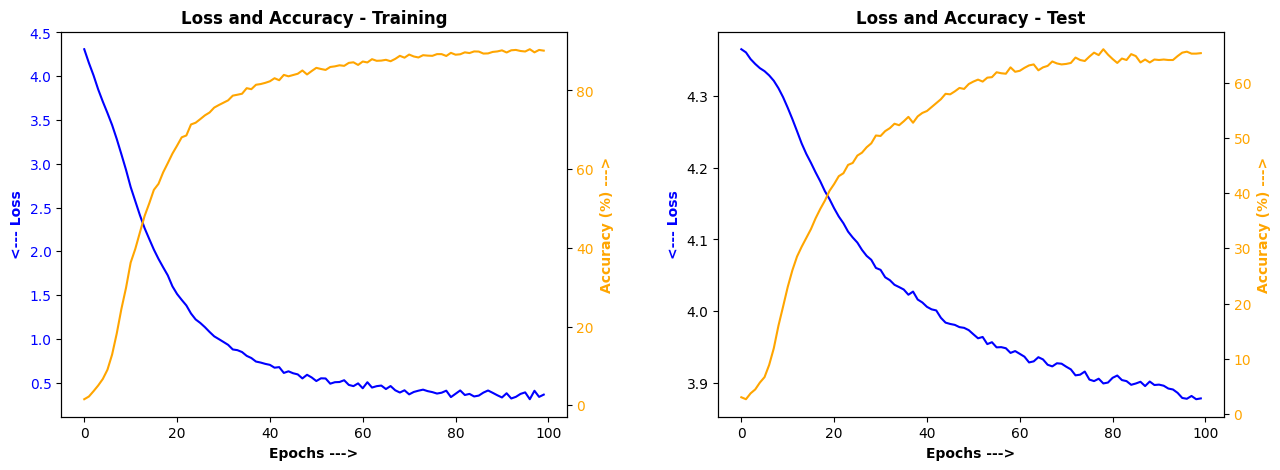

In [ ]:
plot()

# References

1. Miller, A., Fisch, A., Dodge, J., Karimi, A.-H., Bordes, A., & Weston, J. (2016). Key-Value Memory Networks for Directly Reading Documents. In Proceedings of the 2016 Conference on Empirical Methods in Natural Language Processing (pp. 1400–1409). Association for Computational Linguistics. https://doi.org/10.18653/v1/D16-1147

2. Dr. Reidl, M Georgia Institutre of Technology OMSCS Lecture Notes
CS7650 Summer 2024

3. Dr. Reidl, M Georgia Institutre of Technology OMSCS CS7650 Summer 2024 Project 5 Key-Value Memory Networks